In [1]:
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

keras.backend.clear_session()



In [2]:
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed5')

last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)

model = Model(pre_trained_model.input, x)
Adam = tf.keras.optimizers.Adam(learning_rate=0.0009, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=Adam, loss='categorical_crossentropy', metrics=['acc'])



In [3]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)
valid_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = train_datagen.flow_from_directory("D:/paddy_leaf/Rice Leaf Disease Images2-small/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(150, 150),
                                                    shuffle=True)
valid_generator = valid_datagen.flow_from_directory("D:/paddy_leaf/Rice Leaf Disease Images2-small/test",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(150, 150),
                                                    shuffle=False)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)

    return exponential_decay_fn


exponential_decay_fn = exponential_decay(lr0=0.0009, s=5)

lr_scheduler_ed = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
checkpoint_cb = keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
early_stopping_m = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(train_generator,
                    validation_data=valid_generator,
                    steps_per_epoch=45,
                    epochs=30,
                    validation_steps=10,
                    callbacks=[checkpoint_cb, lr_scheduler_ed, early_stopping_m],
                    verbose=1)

model = keras.models.load_model('model.h5')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory("D:/paddy_leaf/Rice Leaf Disease Images2-small/test",
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  target_size=(150, 150),
                                                  shuffle=False)



Found 2164 images belonging to 6 classes.
Found 1128 images belonging to 6 classes.
Epoch 1/30
45/45 [==============================] - 37s 787ms/step - loss: 5.6019 - acc: 0.6165 - val_loss: 1.4135 - val_acc: 0.6400
Epoch 2/30
45/45 [==============================] - 36s 808ms/step - loss: 0.6972 - acc: 0.8337 - val_loss: 0.3158 - val_acc: 0.8650
Epoch 3/30
45/45 [==============================] - 35s 773ms/step - loss: 0.4646 - acc: 0.8411 - val_loss: 0.2840 - val_acc: 0.8800
Epoch 4/30
45/45 [==============================] - 36s 802ms/step - loss: 0.2926 - acc: 0.8933 - val_loss: 0.1123 - val_acc: 0.9650
Epoch 5/30
45/45 [==============================] - 35s 776ms/step - loss: 0.2434 - acc: 0.9167 - val_loss: 0.1638 - val_acc: 0.9300
Epoch 6/30
45/45 [==============================] - 35s 785ms/step - loss: 0.2085 - acc: 0.9140 - val_loss: 0.1760 - val_acc: 0.9150
Epoch 7/30
45/45 [==============================] - 37s 823ms/step - loss: 0.2270 - acc: 0.9222 - val_loss: 0.1472 - v

# Evaluate the model with test images

In [4]:

score = model.evaluate(test_generator, batch_size=1, verbose=1)



1128/1128 [==============================] - 56s 49ms/step - loss: 0.1713 - acc: 0.9282


# Graph between Training Accuracy and Validation Accuracy

<Figure size 432x288 with 0 Axes>

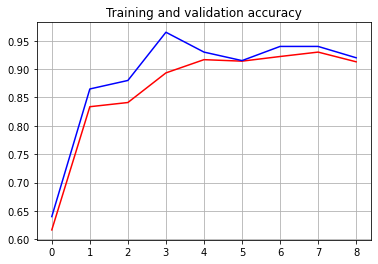

<Figure size 432x288 with 0 Axes>

In [5]:

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(history.epoch, acc, 'r', label='Training accuracy')
plt.plot(history.epoch, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.grid(True)
plt.figure()



# Graph between Training Loss and Validation Loss

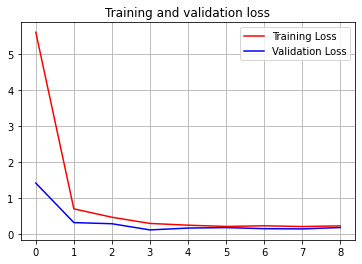

In [6]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid(True)
plt.show()



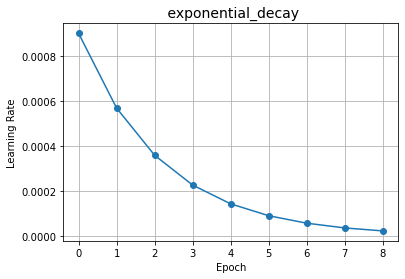

In [7]:
# Graph for Learning rate ~ Exponential Decay
plt.plot(history.epoch, history.history["lr"], "o-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title(" exponential_decay", fontsize=14)
plt.grid(True)
plt.show()



In [8]:
# T0 print the Classification Report
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))




              precision    recall  f1-score   support

           0       0.84      0.97      0.90       245
           1       0.93      0.85      0.89       218
           2       0.92      0.85      0.89       254
           3       1.00      1.00      1.00       196
           4       1.00      0.80      0.89        15
           5       0.98      1.00      0.99       200

    accuracy                           0.93      1128
   macro avg       0.95      0.91      0.93      1128
weighted avg       0.93      0.93      0.93      1128



# print the Confusion Matrix

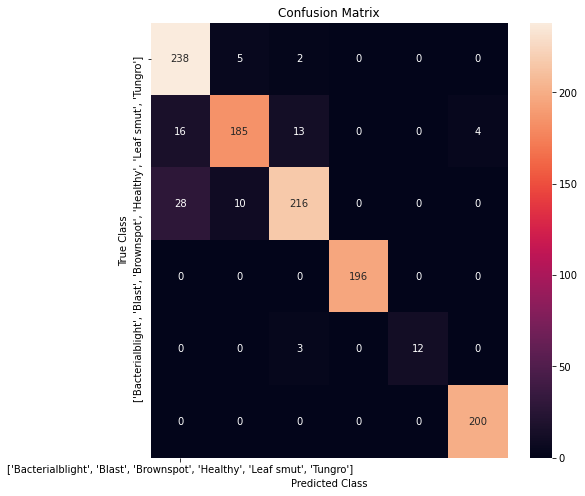

In [9]:

cf_matrix = confusion_matrix(test_generator.classes, y_pred)
Labels = [['Bacterialblight','Blast','Brownspot','Healthy','Leaf smut','Tungro']]
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(cf_matrix, xticklabels=Labels, yticklabels=Labels, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()